In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Dense
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pickle

In [2]:
input_texts=[]
target_texts=[]
input_characters=set()
target_characters = set()

In [3]:
with open('eng-french.txt','r',encoding='utf-8') as f:
    rows=f.read().split('\n')
    # reading and splitting 

In [4]:
for row in rows[:10000]:# limiting data
    
    input_text,target_text = row.split('\t')#splitting input and target text
    target_text='\t' + target_text + '\n' #adding start and and tokens
    #lowercasing and collecting characthers
    input_texts.append(input_text.lower())
    target_texts.append(target_text.lower())
    input_characters.update(list(input_text.lower()))
    target_characters.update(list(target_text.lower()))
    

In [5]:
#Sorting charaecters
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

In [6]:
# caculating total number of character and maximum length

num_en_chars = len(input_characters)
num_dec_chars = len(target_characters)
max_input_length = max([len(i) for i in input_texts])
max_target_length = max([len(i) for i in target_texts])

In [7]:
def bagofcharacters(input_texts,target_texts):
  en_in_data=[] ; dec_in_data=[] ; dec_tr_data=[]
  pad_en=[1]+[0]*(len(input_characters)-1)
  pad_dec=[0]*(len(target_characters)) ; pad_dec[2]=1
  cv=CountVectorizer(binary=True,tokenizer=lambda txt: txt.split(),stop_words=None,analyzer='char')
  for i,(input_t,target_t) in enumerate(zip(input_texts,target_texts)):
    cv_inp= cv.fit(input_characters)
    
    en_in_data.append(cv_inp.transform(list(input_t)).toarray().tolist())
    cv_tar= cv.fit(target_characters)		
    dec_in_data.append(cv_tar.transform(list(target_t)).toarray().tolist())
    dec_tr_data.append(cv_tar.transform(list(target_t)[1:]).toarray().tolist())
    
     
    if len(input_t) < max_input_length:
      for _ in range(max_input_length-len(input_t)):
        en_in_data[i].append(pad_en)
    if len(target_t) < max_target_length:
      for _ in range(max_target_length-len(target_t)):
        dec_in_data[i].append(pad_dec)
    if (len(target_t)-1) < max_target_length:
      for _ in range(max_target_length-len(target_t)+1):
        dec_tr_data[i].append(pad_dec)
  
  
  en_in_data=np.array(en_in_data,dtype="float32")
  dec_in_data=np.array(dec_in_data,dtype="float32")
  dec_tr_data=np.array(dec_tr_data,dtype="float32")

  return en_in_data,dec_in_data,dec_tr_data


In [8]:
en_inputs = Input(shape=(None, num_en_chars))

encoder = LSTM(256, return_state=True)
en_outputs, state_h, state_c = encoder(en_inputs)
en_states = [state_h, state_c]


dec_inputs = Input(shape=(None, num_dec_chars))

dec_lstm = LSTM(256, return_sequences=True, return_state=True)

dec_outputs, _, _ = dec_lstm(dec_inputs, initial_state=en_states)
 
dec_dense = Dense(num_dec_chars, activation="softmax")
dec_outputs = dec_dense(dec_outputs)


model = Model([en_inputs, dec_inputs], dec_outputs)

C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\shash\AppData\Local\Temp\ipykernel_18764\771961326.py:30: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
C:\Users\shash\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


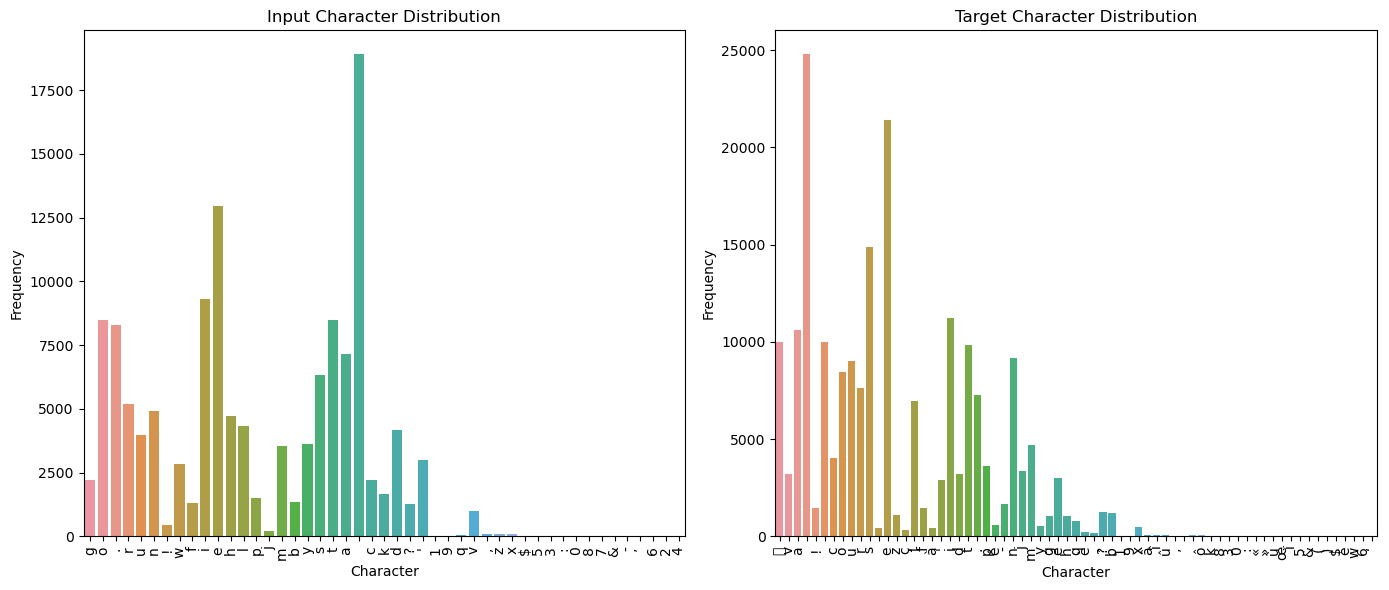

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# Count the characters in input and target texts
input_char_count = Counter("".join(input_texts))
target_char_count = Counter("".join(target_texts))

# Convert to lists for plotting
input_char_labels, input_char_values = zip(*input_char_count.items())
target_char_labels, target_char_values = zip(*target_char_count.items())

# Plot input character distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(input_char_labels), y=list(input_char_values))  # Specify x and y arguments
plt.title('Input Character Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)


# Plot target character distribution
plt.subplot(1, 2, 2)
sns.barplot(x=list(target_char_labels),y=list(target_char_values))
plt.title('Target Character Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



In [9]:
pickle.dump({'input_characters':input_characters,'target_characters':target_characters,
             'max_input_length':max_input_length,'max_target_length':max_target_length,
             'num_en_chars':num_en_chars,'num_dec_chars':num_dec_chars},open("training_data.pkl","wb"))

en_in_data,dec_in_data,dec_tr_data = bagofcharacters(input_texts,target_texts)
model.compile(
    optimizer="adam", aloss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [en_in_data, dec_in_data],
    dec_tr_data,
    batch_size=64,
    epochs=200,
    validation_split=0.2)

model.save("s2s.keras")

C:\Users\shash\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\shash\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:563: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  warnings.warn(


Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.6883 - loss: 1.7682 - val_accuracy: 0.6879 - val_loss: 1.1239
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.7382 - loss: 0.9393 - val_accuracy: 0.7314 - val_loss: 0.9719
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - accuracy: 0.7670 - loss: 0.8636 - val_accuracy: 0.7584 - val_loss: 0.8811
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 310ms/step - accuracy: 0.7990 - loss: 0.7210 - val_accuracy: 0.7689 - val_loss: 0.7929
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.8102 - loss: 0.6540 - val_accuracy: 0.7809 - val_loss: 0.7425
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step - accuracy: 0.8214 - loss: 0.6123 - val_accuracy: 0.7890 - val_loss: 0.7125
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - accuracy: 0.8285 - loss: 0.5852 - val_accuracy: 0.7954 - val_loss: 0.6836
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.8367 -

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, 47)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 67)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         311,296 │ input_layer[0][0]          │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         331,776 │ input_layer_1[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 67)          │          17,219 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,980,875 (7.56 MB)

 Trainable params: 660,291 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,320,584 (5.04 MB)

In [24]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate([en_in_data, dec_in_data], dec_tr_data)
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9859 - loss: 0.0514
Test Accuracy: 0.9630


Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.9884 - loss: 0.0305 - val_accuracy: 0.8589 - val_loss: 0.9767
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.9891 - loss: 0.0271 - val_accuracy: 0.8587 - val_loss: 0.9797
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.9890 - loss: 0.0279 - val_accuracy: 0.8598 - val_loss: 0.9689
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.9893 - loss: 0.0263 - val_accuracy: 0.8594 - val_loss: 0.9714
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.9898 - loss: 0.0245 - val_accuracy: 0.8610 - val_loss: 0.9685
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.9901 - loss: 0.0231 - val_accuracy: 0.8603 - val_loss: 0.9764
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.9901 - loss: 0.0228 - val_accuracy: 0.8601 - val_loss: 0.9769
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9902 -

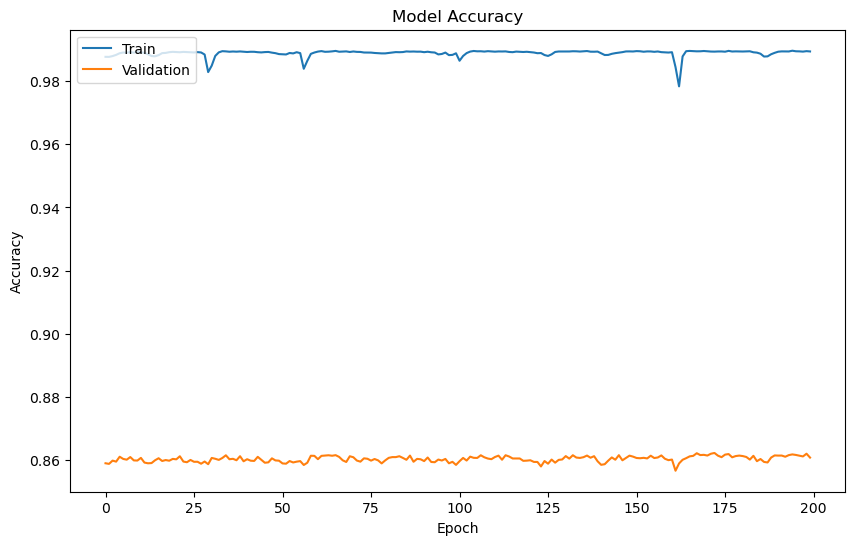

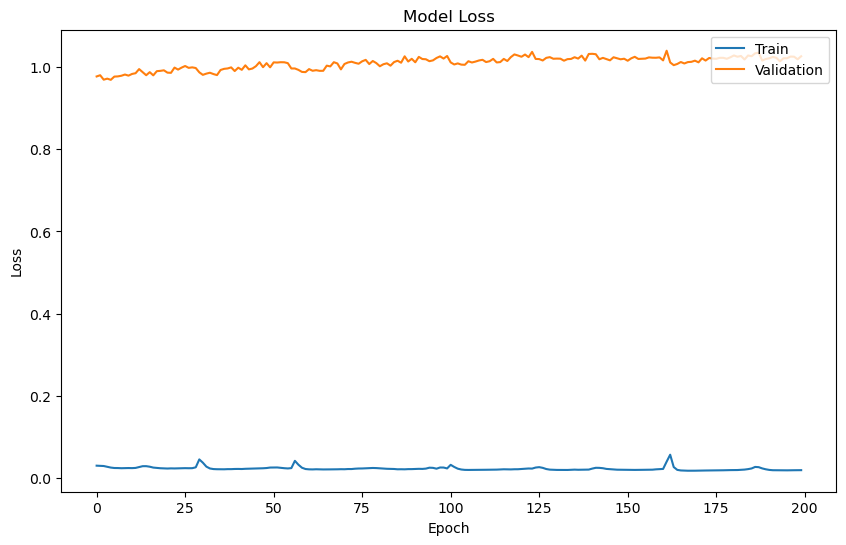

In [25]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit([en_in_data, dec_in_data], dec_tr_data, batch_size=64, epochs=200, validation_split=0.2)



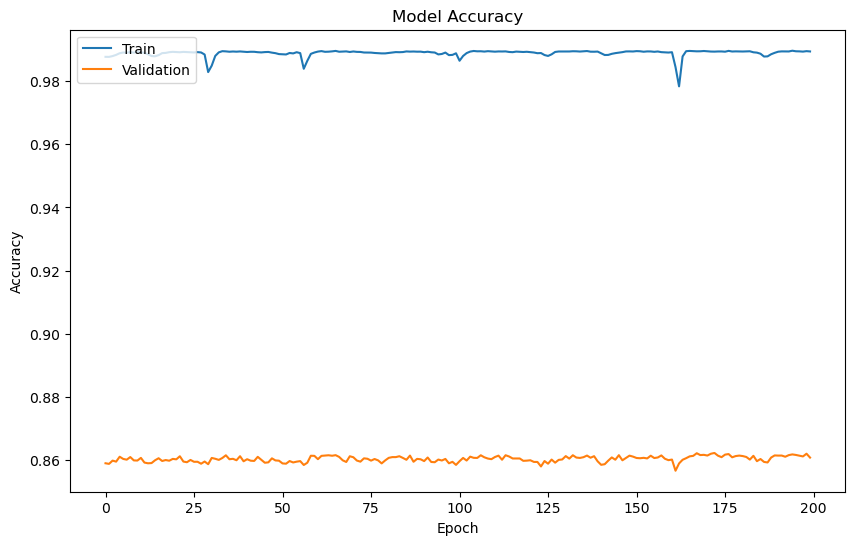

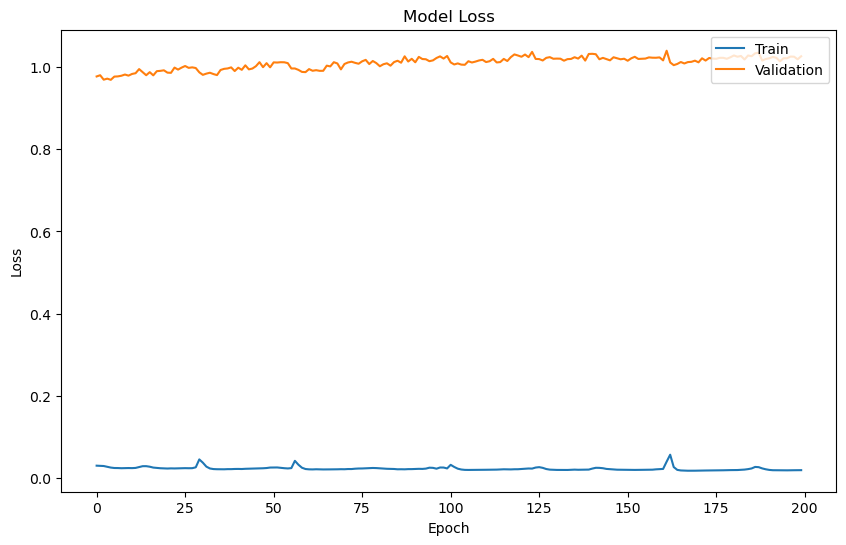

In [26]:
# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()